In [3]:
import os
import random
import time

import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.distributions import Categorical

In [4]:
id= "CartPole-v1"
n=4
timesteps=100000
learningrate= 8e-4
gamma= 0.99
entropyweight= 0.01  #entropy-coeff for loss
valueweight= 0.25  #value-fn coeff for loss (critics influence)
maxnorm= 0.5  #gradient magnitude clipper
path= "videos"

In [5]:
def make_env(id, video, seed=None):
  if video:
    env= gym.make(id, render_mode="rgb_array")
    env= gym.wrappers.RecordVideo(env, path, episode_trigger= lambda episode: True, fps=30)

  else:
    env= gym.make(id)
  env= gym.wrappers.RecordEpisodeStatistics(env)

  return env

In [19]:
class ActorCritic(nn.Module):
  def __init__(self, envs, hidden=128):
    super().__init__()
    self.network= nn.Sequential(
        nn.Linear(envs.single_observation_space.shape[0], hidden),
        nn.ReLU()
    )
    self.actor= nn.Linear(hidden, envs.single_action_space.n)

    self.critic= nn.Linear(hidden, 1)

  def forward(self,x):
      x= self.network(x)
      return self.actor(x), self.critic(x)

In [8]:
envs= gym.vector.SyncVectorEnv([
    lambda: make_env(
        id,
        video= False,
        seed=None)
    for i in range(n)
])

In [20]:
acn= ActorCritic(envs)
opt= torch.optim.Adam(acn.parameters(), lr=learningrate)

In [22]:
def sampleaction(logits):
  dist= Categorical(logits=logits)
  return dist.sample()

In [11]:
def computeentropyandlogprob(logits,actions):
  dist= Categorical(logits=logits)
  return dist.entropy().mean(), dist.log_prob(actions)

In [12]:
def n2t(a):
  return torch.as_tensor(a, dtype=torch.float32)

In [13]:
epreturns=[]
losses=[]

In [29]:
start_time = time.time()
obs, _ = envs.reset(seed=None)
autoreset = np.zeros(n, dtype=bool)

for global_step in range(timesteps):

  # get model output
  action_logits, value = acn(n2t(obs))

  # select action based on current policy
  actions = sampleaction(action_logits)
  actions_np = actions.detach().cpu().numpy()

  # take a step in the environment
  next_obs, rewards, dones, truncateds, infos = envs.step(actions_np)

  # record returns for plotting
  for i, (done, truncated) in enumerate(zip(dones, truncateds)):
    if done or truncated:
      ret = infos['episode']['r'][i]
      epreturns.append(ret)
      print(f"global_step={global_step}, episode={len(epreturns)}, episode_return={ret}")

  # don't forget
  # note: if autoreset is true, next_obs is s(1)
  obs = next_obs

  ### training! ###
  mask = np.logical_not(autoreset)
  value_ = value[mask]
  obs_ = obs[mask]
  actions_ = actions[mask]
  action_logits_ = action_logits[mask]
  rewards_ = rewards[mask]
  next_obs_ = next_obs[mask]
  dones_ = dones[mask]

  # value loss
  with torch.no_grad():
    _, value_next = acn(n2t(next_obs_))
    td_target = n2t(rewards_.flatten()) + \
      gamma * n2t(1 - dones_.flatten()) * value_next.flatten()
  pred = value_.flatten()
  value_loss = F.mse_loss(pred, td_target)

  # policy loss
  # entropy, log_probs = compute_entropy(action_logits_)
  entropy, selected_log_probs = computeentropyandlogprob(
      action_logits_, actions_)
  advantage = td_target - value_
  # log_probs[:, actions]
  # selected_log_probs = log_probs.gather(1, actions_.unsqueeze(1)).squeeze(1)

  # print("log_probs.shape:", log_probs.shape)
  # print("actions_.shape:", actions_.shape)
  # print("selected_log_probs.shape:", selected_log_probs.shape

  policy_loss = -torch.mean(selected_log_probs * advantage.detach())

  # total loss
  loss = policy_loss - entropyweight * entropy + valueweight * value_loss
  losses.append(loss.item())

  if global_step % 100 == 0:
    print("steps per second:", int(global_step / (time.time() - start_time)))

  # gradient descent step
  opt.zero_grad()
  loss.backward()
  # nn.utils.clip_grad_norm_(ac_network.parameters(), max_norm)
  opt.step()

  # update autoreset
  autoreset = np.logical_or(dones, truncateds)

  # let's just break if the last 10 episodes had max reward
  if len(epreturns) > 10 and np.all(np.equal(epreturns[-10:], 500)):
    print("max reward achieved!")
    break

steps per second: 0
global_step=13, episode=1, episode_return=14.0
global_step=13, episode=2, episode_return=14.0
global_step=14, episode=3, episode_return=15.0
global_step=26, episode=4, episode_return=12.0
global_step=32, episode=5, episode_return=33.0
global_step=42, episode=6, episode_return=27.0
global_step=47, episode=7, episode_return=20.0
global_step=47, episode=8, episode_return=14.0
global_step=61, episode=9, episode_return=18.0
global_step=61, episode=10, episode_return=13.0
global_step=62, episode=11, episode_return=48.0
global_step=65, episode=12, episode_return=17.0
global_step=75, episode=13, episode_return=12.0
global_step=75, episode=14, episode_return=13.0
global_step=84, episode=15, episode_return=22.0
global_step=89, episode=16, episode_return=23.0
global_step=90, episode=17, episode_return=14.0
global_step=97, episode=18, episode_return=12.0
global_step=99, episode=19, episode_return=9.0
steps per second: 227
global_step=112, episode=20, episode_return=14.0
global_

In [30]:
def smooth(x, a=0.1):
    y = [x[0]]
    for xi in x[1:]:
        yi = a * xi + (1 - a) * y[-1]
        y.append(yi)
    return y

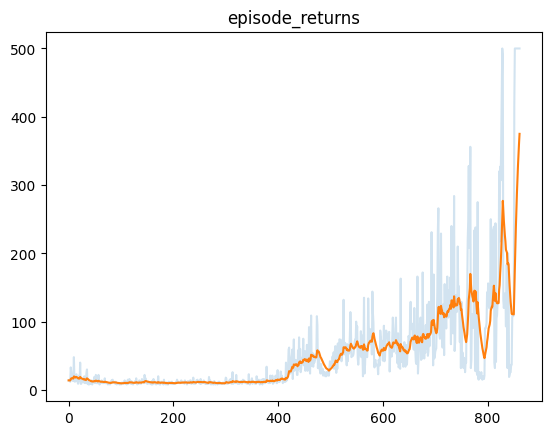

In [31]:
import matplotlib.pyplot as plt
plt.plot(epreturns, alpha=0.2)
plt.plot(smooth(epreturns))
plt.title("episode_returns");
plt.show();

In [33]:
# save model
model_path = "a2c_cartpole.pth"
torch.save(acn.state_dict(), model_path)

In [34]:
# load model for eval
envs_eval = gym.vector.SyncVectorEnv([lambda: make_env(id, True)])
model = ActorCritic(envs_eval)
model.load_state_dict(torch.load(model_path))
model.eval()

ActorCritic(
  (network): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
  )
  (actor): Linear(in_features=128, out_features=2, bias=True)
  (critic): Linear(in_features=128, out_features=1, bias=True)
)

In [35]:
# evaluate model
n_episodes_eval = 10
eval_returns = np.zeros(n_episodes_eval)
obs, _ = envs_eval.reset()
for i in range(n_episodes_eval):
  episode_done = False
  while not episode_done:
    action_logits, _ = model(n2t(obs))

    # select action based on current policy
    actions = sampleaction(action_logits)
    actions_np = actions.detach().cpu().numpy()

    # take a step in the environment
    obs, rewards, dones, truncateds, infos = envs_eval.step(actions_np)

    if dones[0] or truncateds[0]:
      G = infos['episode']['r'][0]
      eval_returns[i] = G
      episode_done = True
      print(f"episode={i}, return={G}")

envs_eval.close()

episode=0, return=435.0


/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"


episode=1, return=439.0
episode=2, return=482.0
episode=3, return=500.0
episode=4, return=447.0
episode=5, return=430.0
episode=6, return=444.0
episode=7, return=468.0
episode=8, return=466.0
episode=9, return=464.0
